In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os
from functools import reduce

from sentence_transformers import SentenceTransformer, CrossEncoder
from ranker import TransformerRanker, CrossEncoderRanker, Classifier
from preprocessor import *
from mapper import Mapper
from display_products import DisplayProducts
from evaluation import *

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def create_ap_df(ingredients, ap_list, column='tfidf_ap'):
    df = pd.DataFrame.from_dict(dict(zip(ingredients, ap_list)).items())
    df.columns = ['ingredient', column]
    return df

In [3]:
# Set input file directory
ip_file_dir = "../Data/Target Data/"

# Get grocery product hierarchy information
group10 = pd.read_csv(os.path.join(ip_file_dir, 
                                   'group10_header.csv'),
                      sep='\t', 
                      low_memory=False)

# Get scraped information for the above products
products = pd.read_csv(os.path.join(ip_file_dir,
                                    'scraped/products.csv'))

# Merge scraped information into the hierarchy table
group10 = pd.merge(group10, products, 
                   how = 'left', on = 'tcin')

# Preprocess the table
group10 = preprocess_df(group10)

In [4]:
group10['title_lower'] = group10['title'].str.lower()

In [5]:
# Find relevant salt products
salt_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SALTS'))
                   |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SALT')))
                   | ((group10['item_type_name'] == 'Spices and Herbs')
                    & (group10['short_desc'].str.contains('SALT')))]

# Find relevant sugar products
sugar_docs = group10[((group10['sub_group_name'] == 'DRY GROCERY') & (group10['subclass_name'] == 'SUGAR'))
                    |((group10['sub_group_name'] == 'DRY GROCERY')
                    & (group10['style_name'].str.contains('SUGAR')))
                    |((group10['item_type_name'] == 'Sugars and Sweeteners')
                    & (group10['short_desc'].str.contains('SUGAR')))]

# Find relevant water products
water_docs = group10[(group10['class_name'] == "DC BASE WATER")]

# Find relevant olive oil products
olive_oil_docs = group10[(group10['subclass_name'] == 'OLIVE OILS')
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['short_desc'].str.contains('OLIVE OIL')))
                         | ((group10['item_type_name'] == 'Cooking and Dipping Oils')
                            & (group10['style_name'].str.contains('OLIVE SPRAY')))]

# Find relevant butter products
butter_docs = group10[(group10['class_name'] == 'BUTTER')]

# Find relevant milk products
milk_docs = group10[group10['class_name'] == 'MILK']

# Find relevant flour products
flour_docs = group10[(group10['class_name'] == 'SUGAR/FLOUR')
                     & (group10['subclass_name'] == 'FLOUR')]

# Find relevant all purpose flour products
all_purpose_flour_docs = group10[(group10['class_name'] == 'SUGAR/FLOUR')
                              & (group10['subclass_name'] == 'FLOUR')
                              & (group10['style_name'] == 'ALL PURPOSE FLOUR')]

# Find relevant baking powder products
baking_powder_docs = group10[(group10['class_name'] == 'BAKING NEEDS')
        & (group10['subclass_name'] == 'INGREDIENTS')
        & (group10['style_name'] == 'BAKING POWDER')]

# Find relevant egg products
egg_docs = group10[group10['item_type_name'] == 'Eggs']

# Vanilla extracts
vanilla_extract_docs = group10[group10['style_name'] == 'VANILLA EXTRACTS']

# Baking Soda
baking_soda_docs = group10[group10['style_name'] == 'BAKING SODA']

# Pepper
pepper_docs = group10[group10['style_name'] == 'GRND BLACK PEPPER']

# Vegetable
vegetable_oil_docs = group10[group10['style_name'] == 'VEGETABLE OIL']

# Garlic
garlic_docs = group10[group10['style_name'].isin(['MINCED GARLIC', 'GARLIC POWDER'])]

# Brown Sugar
brown_sugar_docs = group10[group10['style_name'].isin(['BROWN SUGAR'])]

# Lemon Juice
lemon_juice_docs = group10[(group10['style_name'].isin(['BULK LEMONS'])) | 
                           (((group10['item_type_name'].isin(['Juices'])) 
                           | (group10['subclass_name'].isin(['LEMONS/LIMES'])))  
                           & (group10['short_desc'].str.contains('LEMON')))]

# Lime Juice
lime_juice_docs = group10[(group10['style_name'].isin(['BULK LIMES'])) | 
                           (((group10['item_type_name'].isin(['Juices'])) 
                           | (group10['subclass_name'].isin(['LEMONS/LIMES'])))  
                           & (group10['short_desc'].str.contains('LIME')))]

# Cinnamon
cinnamon_docs = group10[group10['style_name'].isin(['CINNAMON', 'CINNAMON STICKS'])]

# Honey
honey_docs = group10[group10['item_type_name'].isin(['Honey'])]

# Sour Cream
sour_cream_docs = group10[(group10['subclass_name'] == 'SOUR CREAM')]

# Soy Sauce
soy_sauce_docs = group10[(group10['item_type_name'] == 'Sauces and Marinades')
                    & (group10['short_desc'].str.contains('SOY SAUCE'))]

# Granulated Sugar
granulated_sugar_docs = group10[group10['style_name'].isin(['GRANULATED SUGAR'])]

# Cloves
cloves_docs = group10[group10['style_name'].isin(['CLOVES'])]

# Mayonnaise
mayonnaise_docs = group10[(group10['product_subtype_name'] == 'SAUCES, CONDIMENTS AND SPREADS')
                    & (group10['short_desc'].str.contains('MAYO'))]

# Get product list from docs
salt_relevant_docs = list(salt_docs['tcin'].values)
sugar_relevant_docs = list(sugar_docs['tcin'].values)
water_relevant_docs = list(water_docs['tcin'].values)
olive_oil_relevant_docs = list(olive_oil_docs['tcin'].values)
butter_relevant_docs = list(butter_docs['tcin'].values)
milk_relevant_docs = list(milk_docs['tcin'].values)
flour_relevant_docs = list(flour_docs['tcin'].values)
all_purpose_flour_relevant_docs = list(all_purpose_flour_docs['tcin'].values)
baking_powder_relevant_docs = list(baking_powder_docs['tcin'].values)
egg_relevant_docs = list(egg_docs['tcin'].values)
vanilla_extract_relevant_docs = list(vanilla_extract_docs['tcin'].values)
baking_soda_relevant_docs = list(baking_soda_docs['tcin'].values)
pepper_relevant_docs = list(pepper_docs['tcin'].values)
vegetable_oil_relevant_docs = list(vegetable_oil_docs['tcin'].values)
garlic_relevant_docs = list(garlic_docs['tcin'].values)
brown_sugar_relevant_docs = list(brown_sugar_docs['tcin'].values)
lemon_juice_relevant_docs = list(lemon_juice_docs['tcin'].values)
lime_juice_relevant_docs = list(lime_juice_docs['tcin'].values)
cinnamon_relevant_docs = list(cinnamon_docs['tcin'].values)
honey_relevant_docs = list(honey_docs['tcin'].values)
sour_cream_relevant_docs = list(sour_cream_docs['tcin'].values)
soy_sauce_relevant_docs = list(soy_sauce_docs['tcin'].values)
granulated_sugar_relevant_docs = list(granulated_sugar_docs['tcin'].values)
cloves_relevant_docs = list(cloves_docs['tcin'].values)
mayonnaise_relevant_docs = list(mayonnaise_docs['tcin'].values)


# Create ingredient and relevant products mapping
ingredient_docs_map = {}
ingredient_docs_map = dict.fromkeys(['salt', 'kosher salt'], salt_relevant_docs)
ingredient_docs_map.update(dict.fromkeys(['sugar'], sugar_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['water'], water_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['olive oil'], olive_oil_relevant_docs))
ingredient_docs_map.update(dict.fromkeys(['butter'], butter_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['milk'], milk_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['flour'], flour_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['all purpose flour', 'all-purpose flour'], all_purpose_flour_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['baking powder'], baking_powder_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['egg', 'eggs', 'large eggs'], egg_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['vanilla extract', 'vanilla'], vanilla_extract_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['baking soda'], baking_soda_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['pepper', 'black pepper'], pepper_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['vegetable oil'], vegetable_oil_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['garlic'], garlic_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['brown sugar'], brown_sugar_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['lemon juice', 'fresh lemon juice'], lemon_juice_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['lime juice', 'fresh lime juice'], lime_juice_relevant_docs))  
ingredient_docs_map.update(dict.fromkeys(['cinnamon', 'ground cinnamon'], cinnamon_relevant_docs))       
ingredient_docs_map.update(dict.fromkeys(['salt and pepper'], salt_relevant_docs + pepper_relevant_docs))    
ingredient_docs_map.update(dict.fromkeys(['honey'], honey_relevant_docs))                           
ingredient_docs_map.update(dict.fromkeys(['sour cream'], sour_cream_relevant_docs))                           
ingredient_docs_map.update(dict.fromkeys(['soy sauce'], soy_sauce_relevant_docs)) 
ingredient_docs_map.update(dict.fromkeys(['granulated sugar'], granulated_sugar_relevant_docs))   
ingredient_docs_map.update(dict.fromkeys(['cloves, minced', 'cloves'], cloves_relevant_docs))      
ingredient_docs_map.update(dict.fromkeys(['mayonnaise'], mayonnaise_relevant_docs))                                       

In [6]:
import pickle
def get_embeddings(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_embeddings = stored_data['embeddings']
    return stored_embeddings
    
def get_tcin_sentence_map(path):
#Load sentences & embeddings from disc
    with open(path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        df = pd.DataFrame()
        df['tcin'] = stored_data['ids']
        df['sentence'] = stored_data['sentences']
    return df

In [7]:
# Get rankings for multiple ingredients
ingredients = ingredient_docs_map.keys()
relevant_docs_list = ingredient_docs_map.values()
k=20

In [8]:
# Get embeddings for Sentence Transformers 
lm_embedder = SentenceTransformer('all-MiniLM-L6-v2')
glove_embedder = SentenceTransformer('average_word_embeddings_glove.6B.300d')
multi_lm_embedder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
mpnet_embedder = SentenceTransformer('all-mpnet-base-v2')
roberta_embedder = SentenceTransformer('all-distilroberta-v1')
custom_embedder = SentenceTransformer('models/nli')

all_matches = group10['title_lower'].values

In [9]:
glove_embeddings = joblib.load('data/glove_embeddings')
lm_embeddings = joblib.load('data/lm_embeddings')
multi_lm_embeddings = get_embeddings('data/hier_embeddings3.pkl')
mpnet_embeddings = get_embeddings('data/hier_embeddings_mpnet.pkl')
roberta_embeddings = get_embeddings('data/hier_embeddings_roberta.pkl')
custom_embeddings = get_embeddings('data/hier_embeddings3_nli.pkl')

In [16]:
pm = Mapper(group10)
# dp = DisplayProducts(ranker=tr, mapper=pm)
base_clf = CrossEncoder('models/nli-classification-class_name')
clf = Classifier(base_clf, pm, 'class_name', threshold=10)

In [17]:
lm = TransformerRanker(model=lm_embedder, product_ids=group10['tcin'], max_rank=k)
lm.load_embeddings(lm_embeddings)

glove = TransformerRanker(model=glove_embedder, product_ids=group10['tcin'], max_rank=k)
glove.load_embeddings(glove_embeddings)

multi_lm = TransformerRanker(model=multi_lm_embedder, product_ids=group10['tcin'], max_rank=k)
multi_lm.load_embeddings(multi_lm_embeddings)

multi_lm_clf = TransformerRanker(model=multi_lm_embedder, product_ids=group10['tcin'],
                             max_rank=k, clf=clf)
multi_lm_clf.load_embeddings(multi_lm_embeddings)

mpnet = TransformerRanker(model=mpnet_embedder, product_ids=group10['tcin'], max_rank=k)
mpnet.load_embeddings(mpnet_embeddings)

roberta = TransformerRanker(model=roberta_embedder, product_ids=group10['tcin'], max_rank=k)
roberta.load_embeddings(roberta_embeddings)

custom = TransformerRanker(model=custom_embedder, product_ids=group10['tcin'], max_rank=k)
custom.load_embeddings(custom_embeddings)

cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-4-v2', max_length=512)
cr_multi_lm = CrossEncoderRanker(bi_model=multi_lm, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                        cross_rank=k,
                        bi_rank=30)

cr_multi_lm_clf = CrossEncoderRanker(bi_model=multi_lm_clf, 
                        cross_model=cross_encoder_model, 
                        tcin_sentence_map=get_tcin_sentence_map('data/hier_embeddings3.pkl'),
                        cross_rank=k,
                        bi_rank=30)                        

In [18]:
# FastText
from ranker import FastRanker
from fse import Vectors
group10['description'] = np.where(pd.isnull(group10['description']), '', 
                                  group10['description'])
documents = list(group10['title'].str.cat(group10[['description'
                                                        ]], 
                                             sep= ' ').values)
embeddings = Vectors.from_pretrained("paranmt-300")
fr = FastRanker(embeddings, group10, max_rank=k)
fr.fit(documents)

In [19]:
glove_ranker_lists = glove.rank_products_recipe(ingredients)
lm_ranker_lists = lm.rank_products_recipe(ingredients)
multi_lm_ranker_lists = multi_lm.rank_products_recipe(ingredients)
multi_lm_clf_ranker_lists = multi_lm_clf.rank_products_recipe(ingredients)
mpnet_ranker_lists = mpnet.rank_products_recipe(ingredients)
roberta_ranker_lists = roberta.rank_products_recipe(ingredients)
custom_ranker_lists = custom.rank_products_recipe(ingredients)
fr_ranker_lists = fr.rank_products_recipe(ingredients)

Filtered salt for class_name: SPICES
Filtered kosher salt for class_name: SPICES
Filtered olive oil for class_name: SHORTENING/OIL
Filtered milk for class_name: MILK
Filtered all purpose flour for class_name: SUGAR/FLOUR
Filtered all-purpose flour for class_name: SUGAR/FLOUR
Filtered baking powder for class_name: BAKING NEEDS
Filtered large eggs for class_name: EGGS
Filtered vanilla extract for class_name: SPICES
Filtered baking soda for class_name: BAKING NEEDS
Filtered pepper for class_name: SPICES
Filtered black pepper for class_name: MEXICAN/BADIA/GOYA
Filtered vegetable oil for class_name: SHORTENING/OIL
Filtered fresh lemon juice for class_name: CHILLED JUICES
Filtered lime juice for class_name: JUICE
Filtered fresh lime juice for class_name: CHILLED JUICES
Filtered cinnamon for class_name: MEXICAN/BADIA/GOYA
Filtered ground cinnamon for class_name: SPICES
Filtered sour cream for class_name: CULTURED PRODUCTS
Filtered soy sauce for class_name: ASIAN
Filtered granulated sugar for 

In [20]:
cr_multi_lm_ranker_lists = cr_multi_lm.rank_products_recipe(ingredients)

In [21]:
cr_multi_lm_clf_ranker_lists = cr_multi_lm_clf.rank_products_recipe(ingredients)

Filtered salt for class_name: SPICES
Filtered kosher salt for class_name: SPICES
Filtered olive oil for class_name: SHORTENING/OIL
Filtered milk for class_name: MILK
Filtered all purpose flour for class_name: SUGAR/FLOUR
Filtered all-purpose flour for class_name: SUGAR/FLOUR
Filtered baking powder for class_name: BAKING NEEDS
Filtered large eggs for class_name: EGGS
Filtered vanilla extract for class_name: SPICES
Filtered baking soda for class_name: BAKING NEEDS
Filtered pepper for class_name: SPICES
Filtered black pepper for class_name: MEXICAN/BADIA/GOYA
Filtered vegetable oil for class_name: SHORTENING/OIL
Filtered fresh lemon juice for class_name: CHILLED JUICES
Filtered lime juice for class_name: JUICE
Filtered fresh lime juice for class_name: CHILLED JUICES
Filtered cinnamon for class_name: MEXICAN/BADIA/GOYA
Filtered ground cinnamon for class_name: SPICES
Filtered sour cream for class_name: CULTURED PRODUCTS
Filtered soy sauce for class_name: ASIAN
Filtered granulated sugar for 

In [22]:
print('Fast Sentence Embeddings:')
# FastText rankings
fr_map, fr_ap = mean_average_precision(fr_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'FR MAP: {fr_map:.2f}')

print('\nSentence Transformers (L1 Ranker):')
# Glove rankings
glove_map, glove_ap = mean_average_precision(glove_ranker_lists, 
                                             relevant_docs_list, 
                                             return_ap = True)
print(f'Glove MAP: {glove_map: .2f}')

# LM rankings
lm_map, lm_ap = mean_average_precision(lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'LM MAP: {lm_map:.2f}')

# MPNET rankings
mpnet_map, mpnet_ap = mean_average_precision(mpnet_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'MPNET MAP: {mpnet_map:.2f}')

# Roberta rankings
roberta_map, roberta_ap = mean_average_precision(roberta_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Roberta MAP: {roberta_map:.2f}')

# Multi LM rankings
multi_lm_map, multi_lm_ap = mean_average_precision(multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM MAP: {multi_lm_map:.2f}')

# Multi LM CLF rankings
multi_lm_clf_map, multi_lm_clf_ap = mean_average_precision(multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Multi LM CLF MAP: {multi_lm_clf_map:.2f}')

# Custom rankings
custom_map, custom_ap = mean_average_precision(custom_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'Fine Tuned Multi LM MAP: {custom_map:.2f}')

print('\nSentence Transformers (L2 Ranker):')
# CR Multi LM rankings
cr_multi_lm_map, cr_multi_lm_ap = mean_average_precision(cr_multi_lm_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM  MAP: {cr_multi_lm_map:.2f}')

# CR Multi LM CLF rankings
cr_multi_lm_clf_map, cr_multi_lm_clf_ap = mean_average_precision(cr_multi_lm_clf_ranker_lists, 
                                       relevant_docs_list, 
                                       return_ap = True)
print(f'CR Multi LM CLF MAP: {cr_multi_lm_clf_map:.2f}')

Fast Sentence Embeddings:
FR MAP: 0.62

Sentence Transformers (L1 Ranker):
Glove MAP:  0.62
LM MAP: 0.75
MPNET MAP: 0.77
Roberta MAP: 0.68
Multi LM MAP: 0.84
Multi LM CLF MAP: 0.83
Fine Tuned Multi LM MAP: 0.83

Sentence Transformers (L2 Ranker):
CR Multi LM  MAP: 0.90
CR Multi LM CLF MAP: 0.87


In [23]:
# Compare APs at ingredient level
dfs = [create_ap_df(ingredients, multi_lm_ap, 'multi_lm_ap'),
       create_ap_df(ingredients, custom_ap, 'custom_ap'),
       create_ap_df(ingredients, cr_multi_lm_ap, 'cr_multi_lm_ap')]
df_final = reduce(lambda left, right: pd.merge(left, right, on='ingredient'), dfs)

pd.options.display.float_format = '{:,.1f}'.format
df_final

,ingredient,multi_lm_ap,custom_ap,cr_multi_lm_ap
0,salt,0.9,0.9,1.0
1,kosher salt,0.6,0.5,0.3
2,sugar,0.8,0.9,0.9
3,water,0.7,0.5,0.7
4,olive oil,1.0,0.8,1.0
5,butter,0.9,1.0,1.0
6,milk,1.0,1.0,1.0
7,flour,1.0,1.0,1.0
8,all purpose flour,1.0,0.8,1.0
9,all-purpose flour,0.9,0.8,1.0


kosher salt
[13170448, 47088548, 47088764, 49089779, 13170337, 50600605, 13170338, 15420325, 13349062, 50821716]


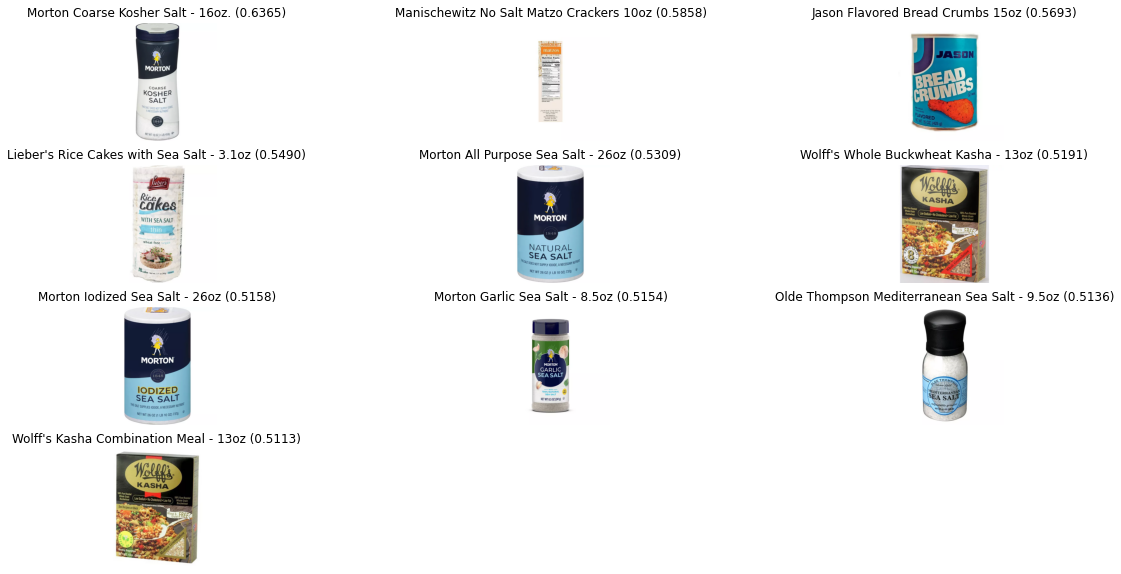

In [24]:
dp = DisplayProducts(ranker=multi_lm, mapper=pm)
dp.display_products_ingredient('kosher salt', 10)

In [17]:
group10[group10['tcin'] == 47088548]


,tcin,item_state,title,update_ts,brand_classification,brand_group,brand_id,brand,class_id,class_name,department_id,department_name,division_id,division_name,estore_item_status_c,estore_item_status,group_id,group_name,has_image,intended_selling_channels,is_published_flag,is_sellable,is_size_mix,is_standard_item,is_targetcom_ready,is_weight_required,item_kind,item_type_category_type,item_type_name,item_type,launch_date_time,manufacturer_brand,net_content_quantity_unit_of_measure,net_content_quantity_value,organic_c,package_depth,package_dimension_unit_of_measure,package_height,package_weight_unit_of_measure,package_weight,package_width,product_subtype_name,product_subtype,product_type_name,product_type,record_source_c,reference_color,reference_pattern_id,reference_size,relationship_kit_type,relationship_type_c,relationship_type,short_desc,size_chart,size_group_name,street_d,style_id,style_name,sub_group_id,sub_group_name,subclass_id,subclass_name,temperature_sensitivity_c,units_per_package,upc,variation_color,variation_other_label,variation_other,variation_size,variation_theme,price,rating,n_reviews,highlights,specifications,description,serving_info,nutrition_info,ingredients,allergens,images,image,title_modified,title_lower,processed
3465,47088548,READY_FOR_LAUNCH,Manischewitz No Salt Matzo Crackers 10oz,2021-09-08 12:06:34,National-National,National,4417,Manischewitz,28,KOSHER,212,MEAL ESSENTIALS,50,DRY GROCERY,A,Active,10,FOOD/BEVERAGE,True,Sold in StoreSold Online,True,True,\N,\N,\N,\N,\N,\N,Crackers,426173,2016-11-17 08:00:00,\N,OUNCE,10,Not organic,7.5,INCH,2.5,POUND,0.79,7.3,SNACK,109516,GROCERY,109420,Corona,\N,\N,\N,\N,SA,Stand Alone,MANISCHEWITZ NO SLT MATZO CRKR 10OZ,\N,\N,\N,212-28-22-ACQ05,A&L,25,DRY GROCERY,212-28-22,KOSHER,\N,1,\N,\N,\N,\N,\N,\N,3.9,4.5,11.0,"[No sodium, Vegetarian, Fat free, Lactose free...","[Origin: Made in the USA or Imported, Features...",Manischewitz No Salt Matzo Crackers is an all ...,"[Serving Size: 32 g, Serving Per Container: 9]","[[Total Fat, 0.5g], [Saturated Fat, 0g], [Tran...","unbleached, unbromated wheat flour and water.",Allergens & Warnings:CONTAINS: WHEAT.,[https://target.scene7.com/is/image/Target/GUE...,https://target.scene7.com/is/image/Target/GUES...,manischewitz no salt matzo crackers,manischewitz no salt matzo crackers 10oz,"[manischewitz, no, salt, matzo, crackers, mani..."


In [18]:
group10[group10['tcin'] == 47088548][['tcin', 'title', 'class_name', 'subclass_name', 'item_type_name', 'style_name']]

,tcin,title,class_name,subclass_name,item_type_name,style_name
3465,47088548,Manischewitz No Salt Matzo Crackers 10oz,KOSHER,KOSHER,Crackers,A&L


In [19]:
group10[group10['tcin'] == 13170448][['tcin', 'title', 'class_name', 'subclass_name', 'item_type_name', 'style_name']]

,tcin,title,class_name,subclass_name,item_type_name,style_name
160,13170448,Morton Coarse Kosher Salt - 16oz.,SPICES,SALTS,Spices and Herbs,SALT


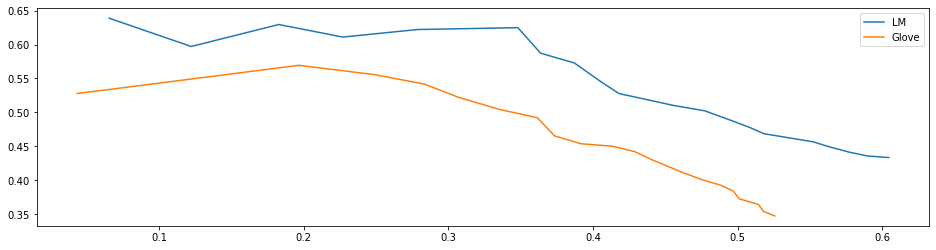

In [57]:
# Precision-Recall Plot for multiple ingredients
lm_avg_precision_list = avg_precision_till(k, lm_ranker_lists, relevant_docs_list)
lm_avg_recall_list = avg_recall_till(k, lm_ranker_lists, relevant_docs_list)
glove_avg_precision_list = avg_precision_till(k, glove_ranker_lists, relevant_docs_list)
glove_avg_recall_list = avg_recall_till(k, glove_ranker_lists, relevant_docs_list)
ranks = list(range(1, 101, 1))

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(lm_avg_recall_list, lm_avg_precision_list, label='LM')
ax.plot(glove_avg_recall_list, glove_avg_precision_list, label='Glove')
plt.legend()
plt.show()